# Clustering Prototype - Initial Version
## Sentence embedding, dimensionality reduction, feature selection, clustering, and explaining clusters.


This file will allow you to set variables to run clustering and explainability on a dataset. In the next cell, you will be able to:

1.   Specify a dataset
     - [IMDB Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) for sentiment analysis
     - [Customer Support Ticket Dataset](https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset)
2.   Specify an embedding method
     - Sentence-BERT ([paper](https://arxiv.org/abs/1908.10084), [documentation](https://www.sbert.net/))
     - LLM2Vec ([paper](https://arxiv.org/abs/2404.05961), [GitHub](https://github.com/McGill-NLP/llm2vec))
2.   Flag if you would like dimensionality reduction (PCA) to occur
3.   Flag if you would like feature selection (decision trees) to occur

Based on these options, the file will run K-means clustering and labeling on the dataset.

Finally, it will prompt an LLM to explain the cluster groupings.


## Set options for clustering

For each of the sections in the following cell, uncomment the option you wish to use for each section and ensure the rest are commented out.

In [12]:
# Dataset --------------------------------------------
dataset = "IMDB.csv"
text_col = "review"
label_col = "sentiment"
# dataset = "helpdesk_customer_tickets.csv"
# text_col =
# label_col =

# Embedding method -----------------------------------
method = "s_bert"
# method = "llm2vec"

# Dimensionality reduction (PCA) ---------------------
pca = True
# pca = False

# Feature selection (decision trees)  ----------------
decision_trees = True
# decision_trees = False

## Imports

Shivani note to venv/docker people: I didn't have to do these pip installs on Colab, but Kerria did for it to work on her PC:

!pip install transformers torch

!pip install -U sentence-transformers

(Disclaimer: only these were really needed to work on my (Kerria's) PC, but it'll probably vary from env to env.)


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [15]:
# Read dataset --------------------------------------------------------------
df = pd.read_csv(dataset)
df = df.sample(frac=0.05)
text = df[text_col]

# Calculate embeddings ------------------------------------------------------
# Note: this is a time-consuming step (~7 min)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(text.tolist(), convert_to_tensor=False)

In [18]:
# Dimensionality Reduction (PCA) --------------------------------------------
if pca:
  pca_model = PCA(n_components=2)
  embeddings_2d = pca_model.fit_transform(embeddings)

## Incorporate feature selection using decision trees

"Shrink" or drop the non-important features with respect to the output class, and "expand" the features that are more important to determining the output class.

In [27]:
# Feature Selection (Decision Trees) ----------------------------------------
if decision_trees:
  X_train, X_test, y_train, y_test = train_test_split(embeddings, df[label_col], random_state = 8, test_size = 0.3)

  # Fit the decision tree model
  decision_tree_model = DecisionTreeClassifier()
  decision_tree_model.fit(X_train, y_train)

  # Access feature importances
  feature_importances = decision_tree_model.feature_importances_

  # Delete low-importance features
  low_importance_indices = np.where(feature_importances < 0.025)[0] # random sampling prob. -- 1/384 = 0.0026
  embeddings_small = np.delete(embeddings, low_importance_indices, axis=1)
  X_train_reduced = np.delete(X_train, low_importance_indices, axis=1)
  X_test_reduced = np.delete(X_test, low_importance_indices, axis=1)
  print(f"Embeddings went from size {len(X_train[0])} to {len(X_train_reduced[0])}")

Embeddings went from size 384 to 4


## K-means clustering

Within-Cluster Sum of Squares: 11.683995246887207


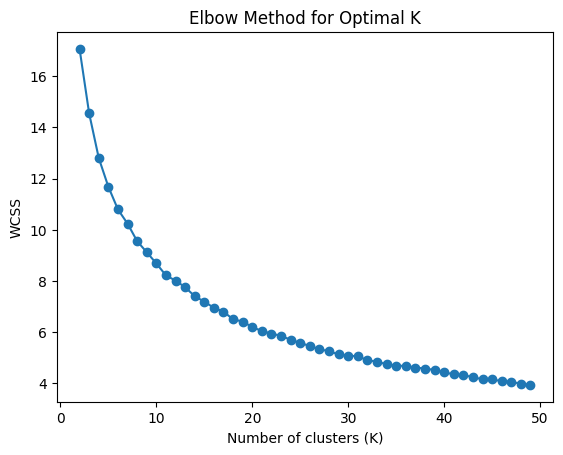

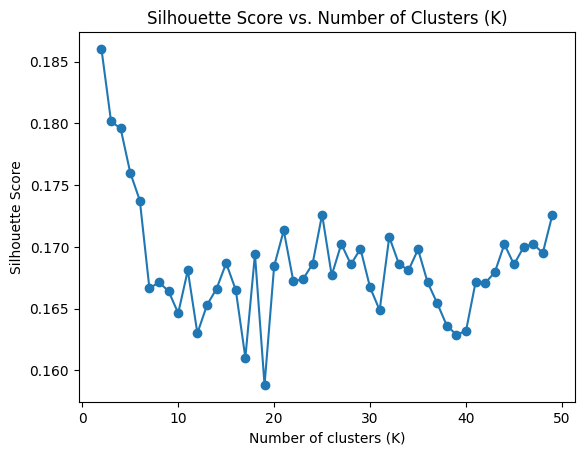

In [31]:
# Perform K-means clustering
num_clusters = 5  # Define the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_small)

# Print WCCS (within-cluster sum of squares) metric
wcss = kmeans.inertia_
print("Within-Cluster Sum of Squares:", wcss)

# NOTE: not sure what to do about this piece below (plotting to determine ideal num clusters)

wcss_list = []  # within-cluster sum of squares
silhouette_scores_list = []

# Calculate WCSS for each K
upper_bound_k = 50
for k in range(2, upper_bound_k):  # Choosing range from 1 to 50 for demonstration
    # wcss
    kmeans_experiment = KMeans(n_clusters=k, random_state=0)
    kmeans_experiment.fit(embeddings_small)
    wcss_list.append(kmeans_experiment.inertia_)

    labels = kmeans_experiment.fit_predict(embeddings_small)
    score = silhouette_score(embeddings_small, labels)
    silhouette_scores_list.append(score)

# Plot the WCSS values
plt.plot(range(2, upper_bound_k), wcss_list, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

# Plot silhouette scores to find optimal K
plt.plot(range(2, upper_bound_k), silhouette_scores_list, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

## Find closest examples to cluster centroids

Currently, we are using cosine similarity to find the data point closest to the cluster centroids as a proxy for explaining or representing that cluster. We can also explore other ways (e.g. using LLMs) to explain clusters.

In [33]:
# For each cluster centroid, print the closest data point
corpus = list(df[text_col])
centroid_embeddings = kmeans.cluster_centers_
for i, centroid_vec in enumerate(centroid_embeddings):
    similarity_scores = util.cos_sim(centroid_vec, embeddings_small)
    closest_data_point = corpus[int(similarity_scores.argmax())]
    print(f"Centroid of cluster {i}:\n-----\n{closest_data_point}\n-----\n\n")

Centroid of cluster 0:
-----
Lloyd Bridges as Mike Nelson and his boat were all the stars of this series. What made it so good to me when I watched it was the real feel of going underwater. The show exhibits a youthful energy energy for exploration under water which is infectious.<br /><br />The show was educational as well showing the viewer things about scuba diving from someone who appeared to be a consummate pro, Mike Nelson. There were excellent shows, and the program always appeared to be well produced. Granted, the drama in the scripts sometimes hit the same notes in more than 1 episode but each show holds it's own with any other show produced during this era, the infancy of American television.
-----


Centroid of cluster 1:
-----
Just to save you money and time I will go ahead and tell you that this movie is absolutely not worth the match and gas it would take to burn it. Don't waste your time. As a matter-of-fact you would be better off forgetting you ever thought about watch

In [37]:
# Print a few data points from each cluster to also help with explainability
for i in range(num_clusters):
    print(f"\n\n\nCluster {i}:")
    samples = df[df['cluster_small-e'] == i][text_col].tolist()[:5]
    for s in samples:
        print("--")
        print(s)
    print("--")




Cluster 0:
--
Forest of the Damned starts out as five young friends, brother & sister Emilio (Richard Cambridge) & Ally (Sophie Holland) along with Judd (Daniel Maclagan), Molly (Nicole Petty) & Andrew (David Hood), set off on a week long holiday 'in the middle of nowhere', their words not mine. Anyway, before they know it they're deep in a forest & Emilio clumsily runs over a woman (Frances Da Costa), along with a badly injured person to add to their problems the van they're travelling in won't start & they can't get any signals on their mobile phones. They need to find help quickly so Molly & Judd wander off in the hope of finding a house, as time goes by & darkness begins to fall it becomes clear that they are not alone & that there is something nasty lurking in the woods...<br /><br />This English production was written & directed by Johannes Roberts & having looked over several other comments & reviews both here on the IMDb & across the internet Forest of the Damned seems to di